In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.optimize import curve_fit
import sympy as sym

#import scipy as sc
#import pandas as pd

import numpy.random as rndm
from numpy.random import uniform as UNFM
#from numpy.random import randint 
#from matplotlib.animation import FuncAnimation

import time
import os
import datetime

import scienceplots
plt.style.use(['science','notebook','grid'])

1 Define all needed functions 
-------------------------------------



SphericalToCartesian

In [6]:
def SphericalToCartesian(theta, phi):
    """Convert spherical coordinates (theta, phi) to Cartesian coordinates (x, y, z).
    Args:
        theta : Polar angle. Scattering angle really. Rotation around the z-axis - in x-y plane, starting from the positive x-axis. Goes from 0 to pi. 
        phi : Azimuthal angle. Angle around the x-axis. Goes from 0 to 2*pi.
    Returns:
        artesian coordinates as a 3-element array [x, y, z].
    """
    x = np.cos(theta)
    y = np.sin(theta) * np.cos(phi)
    z = np.sin(theta) * np.sin(phi)
    return np.array([x, y, z])


NewDirectionUnitVector

In [7]:
def NewDirectionUnitVector(u_old, theta_sc, phi_sc):
    """
    Apply scattering to the old direction vector u_old using the scattering angles theta_sc and phi_sc.
    
    Parameters:
    u_old : np.ndarray
        Original direction (unit vector, shape (3,))
    theta_sc : float
        Scattering polar angle (radians)
    phi_sc : float
        Scattering azimuthal angle (radians)
    
    Returns:
    u_new : np.ndarray
        New direction (unit vector, shape (3,))
    """
    u_old = u_old / np.linalg.norm(u_old)  # Ensure u_old is normalized
    # New direction in local scattering frame, shall already be a unit vector
    u_sc_local = SphericalToCartesian(theta_sc, phi_sc) 
    
    if np.allclose(u_old, [1, 0, 0]):
        return u_sc_local 
    # if u_old is not close to [1,0,0] - normal rotation procedure
    ref_vec = np.array([1, 0, 0])
    # find 2 other orthogonal vectors to u_old
    v = np.cross(ref_vec, u_old)
    v /= np.linalg.norm(v)  # Normalize v
    w = np.cross(u_old, v)  # v is orthogonal to both u_old and v, already a unit vector
    # find the rotation matrix
    R = np.column_stack((u_old, v, w))  # Rotation matrix with columns as local frame vectors
    
    # Apply the rotation to the scattering vector
    u_new = R @ u_sc_local  # Rotate the scattering vector to the global frame
    u_new /= np.linalg.norm(u_new)  # Ensure the new direction is a unit vector
    return u_new

ComptonScatteringInteraction

In [8]:
def ComptonScatteringInteraction(E, u_particle):
    """
    Simulates Compton scattering interaction for a photon. 
    Uses the Klein-Nishina formula to determine the energy and direction of the scattered photon.
    This method is based on Geant4's website description of Compton scattering. Link:
      - https://geant4-userdoc.web.cern.ch/UsersGuides/ForApplicationDeveloper/html/PhysicsReference/Processes/Electromagnetic/ComptonScattering.html
    It is characterised as RNG method, using combined composition and rejection MC method for RNG for K-N Compton energy PDF.

    Parameters:
    E - energy of the incident photon (MeV)
    u_particle - direction of the incident photon (unit vector)
    
    Returns:
    E_scattered - energy of the scattered photon (MeV)
    u_scattered - direction of the scattered photon (unit vector)
    """
    # draw energy fraction perserved after Compton scattering
    m_e = 0.511  # MeV/c^2
    alpha = E / m_e 
    # eps = Es/E; eps_min = minimal energy of scattered photon
    eps_min = 1 / (1 + 2 * alpha)  # Minimum energy of the scattered photon
    beta1 = - np.log(eps_min)
    beta2 = 0.5 * (1 -eps_min**2)
    # Loop to find the scattered energy  - using combined composition and rejection MC method for RNG for K-N Compton energy PDF
    while True:
        r1,r2,r3 = np.random.uniform(0, 1, 3)  # Generate random numbers for the scattering angle
        if r1 < beta1 / (beta1 + beta2):
            eps_prop = eps_min**r2  # geant4 page
        else:
            eps_prop = np.sqrt(eps_min**2 + (1- eps_min**2) * r2) # Geant4, Stuedn 2024
        # condtition to be met before accepting the proposed energy of the scattered photon
        t = (1 - eps_prop) / alpha/ eps_prop
        g_eps = 1 - eps_prop *t*(2-t)/(1+eps_prop**2)
        if g_eps > r3:
            eps = eps_prop
            break

    # Calculate the energy, scattering angles and post-interaction direction of the scattered photon
    E_scattered = E * eps  # MeV
    theta_cs = np.arccos(1 - 1/alpha*(1/eps-1)) # Scattering angle in radians
    phi_cs = 2*np.pi * np.random.uniform(0, 1) 
    u_new = NewDirectionUnitVector(u_particle, theta_cs, phi_cs)

    return E_scattered, u_new

PhotonFreePath

In [9]:
def PhotonFreePath(E,LAC_data):
    """
    Calculate the free path length for photons, with consideration of Compton scattering and photoelectric effect interactions.
    Calculates the free path length based on the linear attenuation coefficients of each interaction and well-knowd exponential attenuation law.

    Parameters:
    E : Energy of the photon (MeV)
    LAC_data : dict
        Dictionary containing energy-dependent linear attenuation coefficients for Compton scattering, photoelectric effect, and pair production.

    Returns:
    Free path length in cm and the type of interaction that will occur ('compton', 'phot', 'pair').
    """
    # Extract energy and linear attenuation coefficients from the LAC data
    energy_list = LAC_data['energy']  # Energy values in MeV
    lac_cs_list = LAC_data['lac_cs']  # Linear attenuation coefficient for Compton scattering (cm^-1)
    lac_pe_list = LAC_data['lac_pe']  # Linear attenuation coefficient for photoelectric
    lac_pp_list = LAC_data['lac_pp']  # Linear attenuation coefficient for pair production (cm^-1)

    # find lac for Cs, PE, PP
    lac_cs = np.interp(E, energy_list, lac_cs_list)  # Compton scattering
    lac_pe = np.interp(E, energy_list, lac_pe_list)  # Photoelectric

    # gerenrate free paths for Compton scattering and photoelectric effect
    u1, u2, u3 = np.random.uniform(0, 1, 3)  # Generate two random numbers for the free path calculation
    s_cs = - np.log(u1) / lac_cs  # Compton scattering free path length
    s_pe = - np.log(u2) / lac_pe  # Photoelectric effect free path length
    
    # separate procedure for PP
    if E > 1.022:
        lac_pp = np.interp(E, energy_list, lac_pp_list)
        s_pp = - np.log(u3) / lac_pp
    else:
        s_pp = np.inf

    ### WHICH TO CHOOSE - A OR B ????????

    # A)
    free_path_length = min(s_cs,s_pe,s_pp)
    # also determine the interaction type
    if free_path_length == s_cs:
        interaction_type = 'compton'
    elif free_path_length == s_pe:
        interaction_type = 'phot'
    elif free_path_length == s_pp:
        interaction_type = 'pair'

    # B)
    # Find the minimum free path and its corresponding interaction type efficiently
    # free_paths = [s_cs, s_pe, s_pp]
    # interaction_types = ['compton', 'phot', 'pair']
    # min_idx = np.argmin(free_paths)
    # free_path_length = free_paths[min_idx]
    # interaction_type = interaction_types[min_idx]
    
    return free_path_length, interaction_type

find_path_length_to_plane - not needed i think

In [10]:
def find_path_length_to_plane(r_particle, u_particle, r_plane, n_plane):
    """
    Find the path length of a particle to the plane.
    
    Parameters:
    r_particle: np.array, position of the particle (3D vector)
    u_particle: np.array, unit vector in the direction of the particle's motion (3D vector)
    r_plane: np.array, point on the plane (3D vector)
    n_plane: np.array, normal vector of the plane (3D vector) - SHOULD BE DIRECTED OUTWARD FROM THE PLANE (or from the 
    inside of the cuboud/rectangle)!!  -- else the code wont work properly!
    
    Returns:
    path_length: float, distance from the particle to the plane
    """
    # Ensure u_particle is a unit vector
    u_particle = u_particle / np.linalg.norm(u_particle)
    n_plane = n_plane / np.linalg.norm(n_plane)
    
    # relative direction of the particle with respect to the plane
    relative_direction_scaling_factor = np.dot(u_particle, n_plane)
    
    # a) if the particle is moving towards the plane, relative_direction_scaling_factor > 0
    if relative_direction_scaling_factor > 0:
        d = np.dot(n_plane, r_particle - r_plane)    
        path_length = abs(d) / relative_direction_scaling_factor
        return path_length
    
    # b) if the particle is moving away from the plane (or parallel to it), relative_direction_scaling_factor < 0
    else:
        return np.inf

BoxPathLenght3D

In [11]:
def BoxPathLength3D(r_particle, u_particle, BoxData):
    """
    Find the path length to the exit of a cuboid/rectangle.
    Also determines the exit face of the cuboid.
    
    Parameters:
    r_particle: np.array, position of the particle (3D vector)
    u_particle: np.array, unit vector in the direction of the particle's motion (3D vector)
    cuboid_dimensions: tuple, dimensions of the cuboid (length, width, height)
    face_normals: list of np.array, normal vectors of the cuboid faces (3D vectors) - should be directed outward from the cuboid
    NEW: adding r_plane, and now instead of cub_dims, arugment of the func is BoxData, which contains 
    the faces' normals and points on the faces besides the cuboid dimensions! - all in all we will sooner or later try
    to work with classes - one reason is this, unefficient code, stupid to have a func that takes arguments that we already 
    predefine (in this case BoxData) and are constant throughout the simulation, ect... 

    Returns:
    path_length: float, distance to the exit of the cuboid
    exit_plane_index: int, index of the exit face (0-5) corresponding to the cuboid faces
    
    Appendix:
    The cuboid is defined by its dimensions (length, width, height) and has 6 faces:
    - Front face (F): x = a/2
    - Back face (B): x = -a/2
    - Left face (L): y = b/2
    - Right face (R): y = -b/2
    - Top face (T): z = c/2
    - Down face (D): z = -c/2
    6 planes: 1-6 or F (forward), B (backward), L (left), R (right), T (top), D (down)
    The function calculates the path length to each face of the cuboid and returns the minimum path length and the index of the exit face.
    The exit face is determined by the minimum path length to the cuboid's faces.
    The function assumes that the particle is moving in a straight line and will exit through the first face it encounters.
    The function uses the equation of a plane to calculate the intersection point of the particle's path with each face of the cuboid.
    The function returns the minimum path length and the index of the exit face.

    """

    ### ALL THIS REGARDING GEOMETRY AND FACES' NORMALES AND VECTORS COULD BE DEFINED BEFORHAND, WHEN GEOMETRY IS INITIALIZED!!! 

    a, b, c = BoxData['cuboid_dimensions']  # unpack dimensions of the cuboid
    face_normals = BoxData['face_normals']  # Normal vectors of the cuboid faces
    r_faces = BoxData['r_faces']  # Points on the cuboid faces


    #### OLD
    # # Define r_plane for each face of the cuboid
    # rF = np.array([a/2,0,0]) # Front face
    # rB = np.array([-a/2,0,0]) # Back face
    # rL = np.array([0,b/2,0]) # Left face
    # rR = np.array([0,-b/2,0]) # Right face
    # rT = np.array([0,0,c/2]) # Top face
    # rD = np.array([0,0,-c/2]) # Down face
    # r_list = [rF, rB, rL, rR, rT, rD]  # List of points on the cuboid faces 
    # # Define the face normals for the cuboid
    # nF = np.array([1,0,0])
    # nB = np.array([-1,0,0])
    # nL = np.array([0,1,0])
    # nR = np.array([0,-1,0])
    # nT = np.array([0,0,1])
    # nD = np.array([0,0,-1])
    # n_list = [nF, nB, nL, nR, nT, nD]  # List of normal vectors for the cuboid faces
    
    # Initialize minimum path length to infinity
    min_path_length = np.inf
    exit_plane_index = -1  # Index of the exit plane (face) with the minimum path length

    # Iterate over each face normal
    for plane_index in range(6):
        r_plane, n_plane = r_faces[plane_index], face_normals[plane_index]  # Get the point on the face and its normal vector        
        
        # ...
        relative_direction_scaling_factor = np.dot(u_particle, n_plane)
        if relative_direction_scaling_factor <= 0:
            # If the particle is moving away from the plane or parallel to it, skip this face
            continue
        path_length_to_plane = np.abs(np.dot(n_plane, r_particle - r_plane)) / relative_direction_scaling_factor
        if path_length_to_plane < min_path_length:
            min_path_length = path_length_to_plane
            exit_plane_index = plane_index  # Update the exit plane index
        
        # # Calculate path length to this face
        # path_length_to_plane = find_path_length_to_plane(r_particle, u_particle, r_plane, n_plane)
        # if path_length_to_plane < min_path_length:
        #     min_path_length = path_length_to_plane
        #     exit_plane_index = plane_index  # Update the exit plane index


    return min_path_length, exit_plane_index

IsotropicDirectionGenerator - also ommited in ParticleStep as code is short!

In [12]:
def IsotropicDirectionGenerator():
    # Isotropic: uniform in cos(theta) and phi
    phi = np.random.uniform(0, 2 * np.pi)         # azimuthal angle
    theta = np.arccos(np.random.uniform(-1,1))    # polar angle

    # Convert spherical to Cartesian coordinates
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    u = np.array([x, y, z])
    
    return u

2 Upload data for material/matter/body energy dependent absorption coefficients for different iteractions
-----

lead

Material: Lead


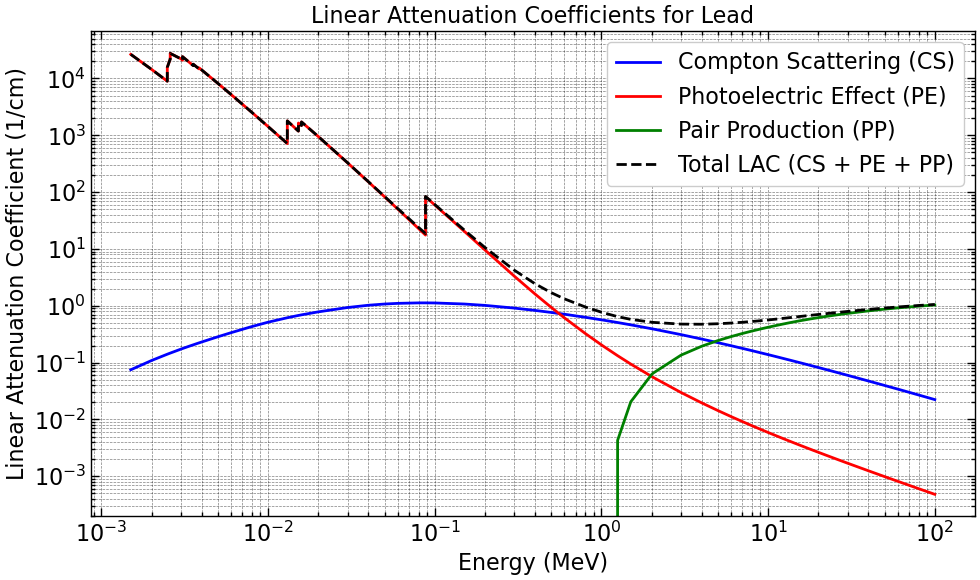

In [3]:
"""
Load a txt file with the data for the mac = mass attenuation coefficient of LEAD
Data is from NISC XCom database.
MAC is in units of cm^2/g
Columns:
 - Energy (MeV) [1kev - 10 MeV]
 - mac_coherent (Rayleigh scattering) [cm^2/g]
 - mac_incoherent (Compton scattering) [cm^2/g]
 - mac_photoelectric (Photoelectric effect) [cm^2/g]
 - mac_pair_production_nuclear (Pair production in nuclear field) [cm^2/g]
 - mac_pair_production_electron (Pair production in electron field) [cm^2/g]
 - mac_total (Total mass attenuation coefficient) [cm^2/g] - sum of all processes
 - mac_tot_w/o_coherent (Total mass attenuation coefficient without Rayleigh scattering) [cm^2/g]
"""
# Load the data from the txt file
data = np.loadtxt('../mac_lead.txt', skiprows=1)
print("Material: Lead")

# Extract the columns
energy_lead = data[:, 0]  # Energy in MeV
mac_coherent_lead = data[:, 1]  # Rayleigh scattering
mac_incoherent_lead = data[:, 2]  # Compton scattering
mac_photoelectric_lead = data[:, 3]  # Photoelectric effect
mac_pair_production_nuclear_lead = data[:, 4]  # Pair production in nuclear field
mac_pair_production_electron_lead = data[:, 5]  # Pair production in electron field
mac_total_lead = data[:, 6]  # Total mass attenuation coefficient
mac_total_w_o_coherent_lead = data[:, 7]  # Total mass attenuation coefficient without Rayleigh scattering

# Define the mass density of lead in g/cm^3
lead_density = 11.34  # g/cm^3

# Convert the mass attenuation coefficients to linear attenuation coefficients [LAC]
lac_coherent_lead = mac_coherent_lead * lead_density  # in 1/cm
lac_incoherent_lead = mac_incoherent_lead * lead_density  # in 1/cm
lac_photoelectric_lead = mac_photoelectric_lead * lead_density  # in 1/cm
lac_pair_production_nuclear_lead = mac_pair_production_nuclear_lead * lead_density  # in 1/cm
lac_pair_production_electron_lead = mac_pair_production_electron_lead * lead_density  # in 1/cm
lac_total_lead = mac_total_lead * lead_density  # in 1/cm
lac_total_w_o_coherent_lead = mac_total_w_o_coherent_lead * lead_density  # in 1/cm

""" 
Further steps to lac data:
 - combine pair production in nuclear and electron fields into one process
 - lac_total_simulation - will consist of CS, PE, PP, but not RS!
 - ...
Label 3 interactions in interest:
 - PP = pair production
 - CS = Compton scattering
 - PE = photoelectric effect 
"""
lac_pp_lead = lac_pair_production_nuclear_lead + lac_pair_production_electron_lead  # in 1/cm
lac_cs_lead = lac_incoherent_lead  # in 1/cm
lac_pe_lead = lac_photoelectric_lead  # in 1/cm
lac_total_simulation_lead = lac_cs_lead + lac_pe_lead + lac_pp_lead  # in 1/cm

# plot lacs for processes in interest
plt.figure(figsize=(10, 6))
plt.plot(energy_lead, lac_cs_lead, label='Compton Scattering (CS)', color='blue')
plt.plot(energy_lead, lac_pe_lead, label='Photoelectric Effect (PE)', color='red')
plt.plot(energy_lead, lac_pp_lead, label='Pair Production (PP)', color='green')       
plt.plot(energy_lead, lac_total_simulation_lead, label='Total LAC (CS + PE + PP)', color='black', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Linear Attenuation Coefficient (1/cm)')
plt.title('Linear Attenuation Coefficients for Lead')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

3 Define Geometry - Box and its dimensions
-

In [9]:
######### BTW: 2 functions from abovw that are used in PhotonStep need extra data:
# 1) PhotonFreePath - needs LAC data for interactions
# 2) BoxPathLength3D - needs cuboid dimensions and face normals to calculate the path length to the exit of the cuboid

define box dimensions

In [4]:
"""
Comments ...
"""

a = 5  # Length of the cuboid in cm
b = 5  # Width of the cuboid in cm
c = 5  # Height of the cuboid in cm
cuboid_dimensions = (a, b, c)  # Dimensions of the cuboid

# Define the face normals for the cuboid
nF = np.array([1, 0, 0])  # Front face normal
nB = np.array([-1, 0, 0])  # Back face normal
nL = np.array([0, 1, 0])  # Left face normal
nR = np.array([0, -1, 0])  # Right face normal
nT = np.array([0, 0, 1])  # Top face normal
nD = np.array([0, 0, -1])  # Down face normal
face_normals = [nF, nB, nL, nR, nT, nD]  # List of face normals

# Define r_plane for each face of the cuboid
rF = np.array([a/2, 0, 0])  # Front face
rB = np.array([-a/2, 0, 0])  # Back face
rL = np.array([0, b/2, 0])  # Left face
rR = np.array([0, -b/2, 0])  # Right face
rT = np.array([0, 0, c/2])  # Top face
rD = np.array([0, 0, -c/2])  # Down face
r_faces = [rF, rB, rL, rR, rT, rD]  # List of points on the cuboid faces


## pack all this in BoxData
BoxData = {
    'cuboid_dimensions': cuboid_dimensions,  # Dimensions of the cuboid
    'face_normals': face_normals,  # Normal vectors of the cuboid faces
    'r_faces': r_faces  # Points on the cuboid faces
}   



In [13]:
# lets try out BoxPathLength3D
r_particle = np.array([0, 0, 0])  # Position of the particle (3D vector)
u_particle = np.array([1, 0, 0])  # Unit vector in the direction of the particle's motion (3D vector)
# Call the function to find the path length to the exit of the cuboid
path_length, exit_face_index = BoxPathLength3D(r_particle, u_particle, BoxData)
print(f"Path length to the exit of the cuboid: {path_length:.2f} cm")
print(f"Exit face index: {exit_face_index}")  # Index of the exit face  


Path length to the exit of the cuboid: 2.50 cm
Exit face index: 0


4 Define a Step Function for photon step processing
-

In [14]:
def ParticleStep(PreStepData,BoxData,LAC_data,Emin_terminate=0.001):
        #eid,tid,r_particle, u_particle, E, cuboid_dimensions, energy_list, lac_cs, lac_pe, lac_pp):
    """
    Comments ...
    Adding eid and tid (event and track id) to the ParticleStep function. No need to add parent id...
    ...
    """
    # unpack the PreStepData
    r_particle = PreStepData['r']  # Position of the particle (3D vector)
    u_particle = PreStepData['u']  # Direction of the particle (unit vector)
    E = PreStepData['E']  # Energy of the particle (MeV)    
    eid = PreStepData['eid']  # Event ID
    tid = PreStepData['tid']  # Track ID
    #### MAYBE I SHOULD SPEARATE EID AND TID FROM THE PRESTEPDATA!! ??
    
    ## unpack BoxData and LaC_data - but no need for that (for now at least)
    # BoxData
    cuboid_dimensions = BoxData['cuboid_dimensions'] # Dimensions of the cuboid (length, width, height)
    face_normals = BoxData['face_normals']  # Normal vectors of the cuboid faces
    r_faces = BoxData['r_faces']  # Points on the cuboid faces
    # LAC data
    energy_list = LAC_data['energy']  # Energy values in MeV
    lac_cs = LAC_data['lac_cs']  # Linear attenuation coefficient for Compton scattering (cm^-1)
    lac_pe = LAC_data['lac_pe']  # Linear attenuation coefficient for photoelectric
    lac_pp = LAC_data['lac_pp']  # Linear attenuation coefficient for pair production (cm^-1)


    # initialize the list of photons added/created during the step to be simulated inside the event
    photons_to_simulate_after_step = []
    # maybe also is good to initialize other variables; like interaction = None ect ..., or maybe no need for this...
    ## eg instead of defining particle_termination for each case, just define it here and set it to
    # False, then only i case of compton it is changed to True ect... -- "live changing/developing code"

    # Determine path length to the exit of the cuboid/rectangle
    box_path_length, exit_plane_index = BoxPathLength3D(r_particle, u_particle, BoxData)
    # Calculate the free path length for the particle
    free_path_length, interaction_type = PhotonFreePath(E, LAC_data)
    
    # compare the path length to the free path length
    if free_path_length > box_path_length:
        interaction_type = 'exit'
        step_length = box_path_length  # Use the path length to the exit of the cuboid
        E_dep = 0.0  # No energy deposited if the particle exits the cuboid
        E_new = E  # Energy remains the same if no interaction occurs
        u_new = u_particle  # Direction remains the same if no interaction occurs
        r_new = r_particle + box_path_length * u_particle  # New position after the step
        particle_termination = True  # Particle is terminated if it exits the cuboid
        event_termination = True  # Event is terminated if the particle exits the cuboid

    else:
        r_new = r_particle + free_path_length * u_particle  # New position after the step
        step_length = free_path_length  # Use the free path length for the step
        exit_plane_index = -1  # Reset exit plane index as the particle is not exiting the cuboid

    # Handle the interaction based on the interaction type
    if interaction_type == 'compton':
        E_new, u_new = ComptonScatteringInteraction(E, u_particle)  # Perform Compton scattering
        E_dep = E - E_new  # Energy deposited in the medium

        # only when compton occurs (i think for now!), the particle energy is to be considered, if it is below the threshold, it is terminated!!
        if E_new < Emin_terminate:
            particle_termination = True  # Particle is terminated if energy is below threshold
            event_termination = True  # Event is terminated if the particle is terminated
        # normally, the particle is not terminated, and the event continues
        else:
            particle_termination = False
            event_termination = False  # Event continues as the particle is not terminated
            # add the scattered photon to the list of photons to be simulated in the event
            photons_to_simulate_after_step.append({
                'eid': eid,  # Event ID
                'tid': tid,  # Track ID
                'E': E_new,  # Energy of the scattered photon
                'u': u_new,  # Direction of the scattered photon
                'r': r_new,  # Position after the step
            })  

    elif interaction_type == 'phot':
        E_new = 0.0  # Photon is absorbed in photoelectric effect
        E_dep = E    
        u_new = None
        particle_termination = True
        event_termination = True  # Event is terminated as the photon is absorbed
        
    
    elif interaction_type == 'pair':
        E_new = 0.0
        E_dep = E - 1.022  # Energy deposited in the medium
        u_new = None  # Direction is not defined after pair production
        particle_termination = True 
        event_termination = False
        
        # Generate two photons from pair production, directions are isotropic and opposite (momentum conservation law)
        phi, th = np.random.uniform(0, 2 * np.pi), np.arccos(np.random.uniform(-1.1))               
        x,y,z = np.sin(th) * np.cos(phi), np.sin(th) * np.sin(phi), np.cos(th)
        u_pp = np.array([x, y, z])
        
        photons_to_simulate_after_step.extend([{'eid':eid, 'tid': tid+1, 'E': 0.511, 'u': u_pp, 'r': r_new},  # First gamma
                                    {'eid':eid, 'tid': tid+2, 'E': 0.511, 'u': -u_pp, 'r': r_new}]) # # Second gamma in opposite direction


    PostStepData = {
        'r': r_new,  # New position after the step
        'u': u_new,  # New direction after the step
        'E': E_new,  # New energy after the interaction

        #'eid': eid,  # Event ID
        #'tid': tid,  # Track ID
        
        # also those kind of thigs?
        #'interaction': interaction_type,  # Type of interaction that occurred
        #'E_dep': E_dep,  # Energy deposited in the medium
        #'step_length': step_length,  # Length of the step taken by the particle
    }

    return {
        'interaction': interaction_type,
        'step_length': step_length,
        'free_path_length': free_path_length,  # Free path length for the particle
        'box_path_length': box_path_length,  # Path length to the exit of the cuboid
        'box_path_length': box_path_length,  # Path length to the exit of the cuboid
        'eid': eid,  # Event ID
        'tid': tid,  # Track ID
        'exit_plane_index': exit_plane_index,
        'E_dep': E_dep,  # Energy deposited in the medium
        'E_new': E_new,  # New energy after interaction
        'u_particle': u_new,  # New direction after interaction
        'r_new': r_new,  # New position after the step
        'particle_termination': particle_termination,  # Termination condition of the particle
        'photons_to_simulate_after_step': photons_to_simulate_after_step,  # List of photons to be simulated
        'event_termination': event_termination,  # Termination condition of the event
        
        # also this?
        #'r': r_particle,  # Original position of the particle
        'PreStepData': PreStepData,  # Original PreStepData
        'PostStepData': PostStepData,  # New PostStepData after the step
        #'BoxData': BoxData,  # Original BoxData

        ## something else??
 }

testing ParticleStep function for one random event ...

In [ ]:
# lets try out the ParticleStep function

# Example PreStepData
PreStepData = {
    'eid': 1,  # Event ID
    'tid': 1,  # Track ID
    'r': np.array([0.01, 0.0, 0.0]),  # Initial position of the particle (3D vector)
    'u': IsotropicDirectionGenerator(),  # Initial direction of the particle (unit vector)
    'E': 2.0,  # Initial energy of the particle (MeV)
}

# Example BoxData
BoxData = {
    'cuboid_dimensions': cuboid_dimensions,  # Dimensions of the cuboid
    'face_normals': face_normals,  # Normal vectors of the cuboid faces
    'r_faces': r_faces,  # Points on the cuboid faces
}

# Example LAC_data
LAC_data = {
    'energy': energy_lead,
    'lac_cs': lac_cs_lead,
    'lac_pe': lac_pe_lead,
    'lac_pp': lac_pp_lead,
}

result = ParticleStep(PreStepData, BoxData, LAC_data)
print(result)

{'interaction': 'exit', 'step_length': 3.0542218937520356, 'free_path_length': 5.544739045307317, 'box_path_length': 3.0542218937520356, 'eid': 1, 'tid': 1, 'exit_plane_index': 2, 'E_dep': 0.0, 'E_new': 2.0, 'u_particle': array([ 0.36792719,  0.81853909, -0.44116136]), 'r_new': array([ 1.13373127,  2.5       , -1.34740469]), 'particle_termination': True, 'photons_to_simulate_after_step': [], 'event_termination': True, 'PreStepData': {'eid': 1, 'tid': 1, 'r': array([0.01, 0.  , 0.  ]), 'u': array([ 0.36792719,  0.81853909, -0.44116136]), 'E': 2.0}, 'PostStepData': {'r': array([ 1.13373127,  2.5       , -1.34740469]), 'u': array([ 0.36792719,  0.81853909, -0.44116136]), 'E': 2.0}}


In [15]:
def PhotonPropagationSimulation(Nsim, SourcePhotons_template, BoxData, LAC_data, Emin_terminate=0.001):
    """
    Simulate Nsim photon events. Each event propagates photons until all are terminated.
    Parameters:
     - Nsim: Number of simulation events
     - SourcePhotons_template: Template for the initial photon data (eid, tid=1, r, u, E)

    For each step, print event id, track id, interaction type, and deposited energy. - for testing
    """
    for eid in range(Nsim):
        
        print(f"\n=== Starting Event {eid} ===")
        # Initialize photon queue for this event
        photons_to_simulate = [{
            'eid': eid,
            'tid': 1,
            'r': SourcePhotons_template['r'],
            'u': SourcePhotons_template['u'],
            'E': SourcePhotons_template['E'],
        }]
        
        event_termination = False
        while not event_termination and photons_to_simulate:
            # Pop the next photon to simulate
            PreStepData = photons_to_simulate.pop(0)
            result = ParticleStep(PreStepData, BoxData, LAC_data, Emin_terminate)
            # Print step info
            print(f"Event {result['eid']} | Track {result['tid']} | Interaction: {result['interaction']} | E_dep: {result['E_dep']:.4f} MeV")
            # Add any new photons to the queue 
            photons_to_simulate.extend(result['photons_to_simulate_after_step'])
            # Check if event is terminated
            event_termination = result['event_termination']




define all parameters

In [2]:
# Example usage:
SourcePhotons_template = {
    'r': np.array([0.01, 0.0, 0.0]),
    'u': IsotropicDirectionGenerator(),
    'E': 2.0,
}
BoxData = {
    'cuboid_dimensions': cuboid_dimensions,
    'face_normals': face_normals,
    'r_faces': r_faces,
}
LAC_data = {
    'energy': energy_lead,
    'lac_cs': lac_cs_lead,
    'lac_pe': lac_pe_lead,
    'lac_pp': lac_pp_lead,
}



NameError: name 'IsotropicDirectionGenerator' is not defined

simulate

In [ ]:
PhotonPropagationSimulation(Nsim=15, SourcePhotons_template=SourcePhotons_template, BoxData=BoxData, LAC_data=LAC_data)


prinitng stuff to a txt file

In [29]:
from datetime import datetime

# The file "AddInfoFile.txt" will be created in the current working directory if it does not already exist.
# You can check the current working directory with:
print("Current working directory:", os.getcwd())

# Generate a timestamped filename at the start of the script

# Create a global variable to hold the filename, generated once per run
timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
addinfo_filename = f"output_data/AddInfoFile_{timestamp_str}.txt"

def Add(a, b):
    """
    Add two numbers a and b, and save info to a timestamped txt file.
    """
    code_exectuion_time = time.time()
    result = a + b

    # Save a, b, result, exec_time to the timestamped file
    with open(addinfo_filename, "a") as f:
        f.write(f"{a} {b} {result} {code_exectuion_time}\n")

    return result

# lets now run code for 10 differnet pairs of a and b and let 's see if the file is created and filled with data
#with open("AddInfoFile.txt", "w") as f:
#    f.write("\nNew run:")  # Header for the file
for i in range(20):
    a = np.random.uniform(0, 10)
    b = np.random.uniform(0, 10)
    result = Add(a, b)
    print(f"Adding {a} and {b} gives {result}")



Current working directory: c:\Users\Admin\Desktop\MAGISTERIJ\4. semester\ZF - zdravstvnea_fizika\simulacije\1-Bulid-up faktor\code
Adding 9.236767333986556 and 7.775437906889385 gives 17.012205240875943
Adding 1.9987641265011846 and 0.2585952311522288 gives 2.2573593576534137
Adding 0.4576493321571218 and 5.324802446594821 gives 5.782451778751943
Adding 5.7291138848528895 and 5.041126531959187 gives 10.770240416812076
Adding 0.6357399459797874 and 4.636775871905411 gives 5.272515817885198
Adding 6.148851804325767 and 9.484774659454745 gives 15.633626463780512
Adding 6.870565825454652 and 2.3620375441707173 gives 9.23260336962537
Adding 4.342078514530733 and 1.1300939088268858 gives 5.472172423357618
Adding 7.768413038960892 and 6.847689577218903 gives 14.616102616179795
Adding 8.091599485107464 and 9.363344990661354 gives 17.45494447576882
Adding 1.7111728078389443 and 5.163824970789359 gives 6.874997778628304
Adding 6.571531057753267 and 0.9250135005945825 gives 7.49654455834785
Addin

1. one option - save data, stored in array-like shape to txt file - post-simulation

In [19]:
data_random = np.random.uniform(0, 1, (100, 3))  # Generate random data
np.savetxt("output_data/random_data.txt", data_random, header="Random data (3 columns)", fmt='%.4f')

2. other option would be to save while running simulation

In [3]:
# code...

SimpleParticlePropagationSimulation class - to find what is optimal class build for simulation

In [ ]:
class SimpleParticlePropagationSimulation:

    def __init__(self, lac):
        """
        This class is a simple Monte Carlo simulation class for testing purposes.
        It simulates a particle moving through a medium with a given linear attenuation coefficient (lac).
        Has 2 main methods: StepForward and RunSimulation:
         - StepForward: performs a single step forward in the simulation, updating the position and scattering angle of the particle.
         - RunSimulation: runs the simulation for a given number of events/initialized photons, runnning StepForward for each step of
         each event until the particle is terminated.
        
        [ABOUT GENERAL APPROACH TO MC SIMULATION OF PARTICLE PROPAGATION]
         - Using StepForward method (in Geant4 eg called ProcessHits) is common in MC simulations of particles propagation through 
        medium. In a simulated step, the particle moves from position of last interaction to the position of new interaction, 
        new interaction is drawn, some tallis like eg energy, interaction type, scattering angle, and new position are 
        returned or updated. For each source particle, steps are simulated one-by-one until some condtion is met
        (eg. boundary of medium, interaction where particle ceases to exist - photoeffect for one, or some other termination
        condition). In real MC simulations, the StepForward method is complex and would also consider the physics of the interactions,
        complex geometry of the medium, and other factors like energy loss, scattering, and particle types. But here,
        the goal is to keep it simple and focus on the structure of the code, how to write methods, how to use them,
        and how to return data from them.
         - ... 

        [ABOUT THIS CLASS]
        In this example class, goal is not to simulate any real physics, but to show how a simple MC simulation class and mostly to
        learn how shall I structure the code, how to write methods, how to use them, how to return data from them, ect. 
        End goal is to have a class that works, is easy to read and use, and also is efficient: time-wise and code-wise. By that 
        I mean that time of simulation is as low as possible as no unnecessary calculations or definitions ect. are done
        over and over again. Somewhat connected to that is also code-wise efficiency, meaning that the code is structured in a way
        that it is easy to read, understand, and use. Here the goal is also to find out how to eg collect and save data of 
        the simulation, what kind of varible types are common and useful and easy to deal with (eg shall i work 
        with dicts, lists, tuples, or some other data structures), how and what data to return from the methods ect. 


        
        [ADITIONAL IDEAS ect.]
         - One idea is to have general code that could be used also for different scenarios, with different parameters
           (like different geomotery, differnet material, energies, also particels ect...), and that can be easily extended
           with new methods, parameters, and functionalities. 
        - One idea for later is also to convert this code in python to C++ in order to build efficinet and working simulation
        class so i can simulate particle propagation with C++ as it is much faster, but slightly more complex to write and use.


        Parameter: lac : float, linear attenuation coefficient (1/cm)
        """

        self.lac = lac
        print(f"Initialized SimpleMCSimulationClass with LAC: {lac} /cm")

    def StepForward(self,position, max_position=10):
        """
        Perform a particle step forward in the simulation. It is naive and does not consider any interactions. 
        Just for testing purposes.
        Parameters:
        position : np.array, current position of the particle (1D array)
        max_position : float, maximum position the particle can reach before termination (default is 10)
        Returns:
        pos_new : np.array, new position of the particle after the step (1D array
        theta : float, scattering angle of the interaction (in radians)
        particle_termination : bool, whether the particle is terminated (True) or not (False)

        This method simulates a single step forward in the simulation, updating the position and scattering angle of the particle.
        It uses an exponential distribution to determine the step length, and a random angle for scattering.
        The particle is terminated if it moves too far away from the initial position (max_position).
        The method returns the new position, scattering angle, and a termination condition for the particle.
        It is a simple example of how a step in a Monte Carlo simulation could be structured.

        [TO CONSIDER]
         - here almost no variables are actual attributes of the class, but are passed as parameters to the method. Maybe
        it is better to have them as attributes of the class, so they are defined once and can be used in all methods of the class.
         - also, maybe it is better to return a dict with the new position, angle, and termination condition, instead of returning
        them as separate variables. This way, the method can return more information if needed, and it is easier to extend the method in the future.
         - also, maybe it is better to have a method that updates the position and angle of the class instance, instead of returning them.
        
        """
        particle_termination = False  ## is having this parameter necessary, usefull, smart idea, or could i repack
        # the info about the particle termination in some other way??

        # Update the position by moving forward by step_length, which is drawn from an exponential distribution
        step_length = - 1/self.lac * np.random.uniform()
        pos_new = position + step_length 
        # lets create a condition to terminate the particle if it goes too far away from the initial position
        if pos_new > max_position:  # Arbitrary condition for termination
            print("Particle terminated: moved too far away from the initial position.")
            pos_new = max_position # Set to max position if terminated
            theta = 0.0  # No scattering angle if the particle is terminated
            particle_termination = True  # Particle is terminated if it goes too far away

        # draw also a scattering angle of the interaction, just take random angle fro now and dont even consider the direction
        #  of the particle, as if direction is constant, just for testing purposes
        theta = np.random.uniform(0, 2 * np.pi)  # Random angle

        # A) return 2 numbers and particle termination condition
        return pos_new, theta, particle_termination  # New position and angle, termination condition
        # B) return a dict with the new position and angle
        # return {
        #     'pos_new': pos_new,  # New position after the step
        #     'theta': theta,  # Scattering angle 
        #     'particle_termination': particle_termination,  # Termination condition of the particle
        # }
        # C) one option would be also that the method does not return anything, but updates the position and angle (as attributes)
        #  of the class instance!! - to consider later!!

    def RunSimulation(self, Nevents=10,photon_init_data):
        """
        Run the simulation for a given number of photons/events.
        Parameters:
        Nevents : int, number of events to run the simulation
        photon_init_data : dict, initial data for the photons (position and angle)
        Returns:
         --> info about ...

        """
        for event in range(Nevents):
            print(f"\n=== Starting Event {event + 1}/{Nevents} ===")
            # Initialize the position and angle of the particle for this event
            init_position = photon_init_data['position']
            init_theta = photon_init_data['theta']

            # create a list for storing the results of each step
            self_position_history = [self.position.copy()]  # Store initial position
            self_theta_history = [self.theta]

        for step in range(num_steps):
            print(f"Step {step + 1}/{num_steps}")
            # Update the position and theta with step forward
            self.position, self.theta = self.StepForward(self.position)
            # Store the new position and theta
            self_position_history.append(self.position.copy())
            self_theta_history.append(self.theta)
        
        print("Simulation completed.")
        
        return {
            'position_history': self_position_history,  # History of positions
            'theta_history': self_theta_history,  # History of theta angles
            'final_position': self.position,  # Final position after the simulation
            'final_theta': self.theta,  # Final theta angle after the simulation
        }
    
    def RunOneEvent(self, num_steps=10,init_position=np.array([0.0, 0.0, 0.0]),init_theta=0.0):
        """
        Run the simulation for a given number of steps.
        Parameters:
        num_steps : int, number of steps to run the simulation
        """
        self.position = init_position  # Initialize the position
        self.theta = init_theta

        print(f"Running simulation for {num_steps} steps with initial position {self.position} and theta {self.theta}")
        # create a list for storing the results of each step
        self_position_history = [self.position.copy()]  # Store initial position
        self_theta_history = [self.theta]

        for step in range(num_steps):
            print(f"Step {step + 1}/{num_steps}")
            # Update the position and theta with step forward
            self.position, self.theta = self.StepForward(self.position)
            # Store the new position and theta
            self_position_history.append(self.position.copy())
            self_theta_history.append(self.theta)
        
        print("Simulation completed.")
        
        return {
            'position_history': self_position_history,  # History of positions
            'theta_history': self_theta_history,  # History of theta angles
            'final_position': self.position,  # Final position after the simulation
            'final_theta': self.theta,  # Final theta angle after the simulation
        }
        
            
            
            

        



##  PhotonPropagationSimulation function documentation

"""
PhotonPropagationSimulation: Monte Carlo simulation of photon transport and interactions in a 3D box of material (e.g., lead).

Overview:
----------
This function simulates the propagation and interactions of monoenergetic photons emitted from a point source inside a cuboid (box) of material.
The simulation tracks each photon as it moves through the material, undergoes possible interactions (Compton scattering, photoelectric effect, or pair production),
and generates secondary photons as needed (e.g., from pair production). The simulation continues until all photons in an event are terminated (absorbed or exit the box).

Simulation Structure:
---------------------
- The simulation runs for Nsim events. Each event starts with a single source photon.
- For each event, a queue of photons to simulate is maintained. New photons (from pair production or Compton scattering) are added to this queue.
- The main loop processes each photon in the queue using the ParticleStep function, which determines the photon's fate (interaction, absorption, exit, or secondary photon creation).

Key Functions Used:
-------------------
1. ParticleStep:
    - Handles the propagation of a single photon for one step.
    - Determines the distance to the next interaction (using PhotonFreePath) and the distance to the box boundary (using BoxPathLength3D).
    - Decides whether the photon interacts or exits the box.
    - Handles the physics of each interaction:
        * Compton scattering: updates energy/direction, possibly continues tracking the photon.
        * Photoelectric effect: photon is absorbed and terminated.
        * Pair production: photon is terminated, two 511 keV photons are created and added to the queue.
    - Returns information about the step, including deposited energy, new photon states, and termination flags.

2. BoxPathLength3D:
    - Calculates the minimum distance from the current photon position to the nearest box face in the direction of motion.
    - Determines which face the photon would exit if it does not interact first.

3. PhotonFreePath:
    - Calculates the random free path length to the next interaction, based on the energy-dependent linear attenuation coefficients (LACs) for each process.
    - Randomly selects the interaction type (Compton, photoelectric, or pair production) according to their probabilities.

4. ComptonScatteringInteraction:
    - Simulates the outcome of a Compton scattering event.
    - Computes the new energy and direction of the scattered photon using the Klein-Nishina formula and random sampling.
    - Uses helper functions NewDirectionUnitVector and SphericalToCartesian for direction calculations.

Arguments:
----------
Nsim : int
    Number of simulation events (each event starts with one source photon).
SourcePhotons_template : dict
    Template dictionary specifying the initial state of the source photon (position, direction, energy).
BoxData : dict
    Contains geometry information for the box (dimensions, face normals, face positions).
LAC_data : dict
    Contains energy-dependent linear attenuation coefficients for all relevant photon interactions.
Emin_terminate : float, optional
    Minimum photon energy threshold (MeV) below which photons are immediately terminated (default: 0.001 MeV).

Output:
-------
- For each step, prints event and step information (for testing/debugging).
- The function can be extended to collect and save detailed interaction data for further analysis.

Notes:
------
- The simulation is modular: each physical process is encapsulated in its own function for clarity and extensibility.
- The code is structured for easy transition to a class-based design in the future.
- All geometry and material data are passed as arguments, making the simulation flexible for different setups.

Example Usage:
--------------
SourcePhotons_template = {
    'r': np.array([0.01, 0.0, 0.0]),
    'u': IsotropicDirectionGenerator(),
    'E': 2.0,
}
PhotonPropagationSimulation(Nsim=100, SourcePhotons_template=SourcePhotons_template, BoxData=BoxData, LAC_data=LAC_data)
"""

Now, try to create class instead of working with fucntions

In [142]:
class PhotonBoxSimulator:
    def __init__(self, BoxData, LAC_data, Emin_terminate=0.001):
        self.BoxData = BoxData
        self.LAC_data = LAC_data
        self.Emin_terminate = Emin_terminate
        
        # Define constants once at initialization instead of in methods
        self.m_e = 0.511  # Electron rest mass energy in MeV
        self.pair_production_threshold = 1.022  # MeV
        self.annihilation_energy = 0.511  # MeV per gamma in pair production
        
        # Pre-extract frequently used LAC data for efficiency
        self.energy_list = self.LAC_data['energy']
        self.lac_cs_list = self.LAC_data['lac_cs']
        self.lac_pe_list = self.LAC_data['lac_pe'] 
        self.lac_pp_list = self.LAC_data['lac_pp']
        
        # Pre-extract box geometry data
        self.cuboid_dimensions = self.BoxData['cuboid_dimensions']
        self.face_normals = self.BoxData['face_normals']
        self.r_faces = self.BoxData['r_faces']

    def SphericalToCartesian(self, theta, phi):
        x = np.cos(theta)
        y = np.sin(theta) * np.cos(phi)
        z = np.sin(theta) * np.sin(phi)
        return np.array([x, y, z])

    def NewDirectionUnitVector(self, u_old, theta_sc, phi_sc):
        u_old = u_old / np.linalg.norm(u_old)
        u_sc_local = self.SphericalToCartesian(theta_sc, phi_sc)
        if np.allclose(u_old, [1, 0, 0]):
            return u_sc_local
        ref_vec = np.array([1, 0, 0])
        v = np.cross(ref_vec, u_old)
        v /= np.linalg.norm(v)
        w = np.cross(u_old, v)
        R = np.column_stack((u_old, v, w))
        u_new = R @ u_sc_local
        u_new /= np.linalg.norm(u_new)
        return u_new

    def ComptonScatteringInteraction(self, E, u_particle):
        # Use pre-defined constant instead of defining it each time
        alpha = E / self.m_e
        eps_min = 1 / (1 + 2 * alpha)
        beta1 = - np.log(eps_min)
        beta2 = 0.5 * (1 - eps_min ** 2)
        while True:
            r1, r2, r3 = np.random.uniform(0, 1, 3)
            if r1 < beta1 / (beta1 + beta2):
                eps_prop = eps_min ** r2
            else:
                eps_prop = np.sqrt(eps_min ** 2 + (1 - eps_min ** 2) * r2)
            t = (1 - eps_prop) / alpha / eps_prop
            g_eps = 1 - eps_prop * t * (2 - t) / (1 + eps_prop ** 2)
            if g_eps > r3:
                eps = eps_prop
                break
        E_scattered = E * eps
        theta_cs = np.arccos(1 - 1 / alpha * (1 / eps - 1))
        phi_cs = 2 * np.pi * np.random.uniform(0, 1)
        u_new = self.NewDirectionUnitVector(u_particle, theta_cs, phi_cs)
        return E_scattered, u_new

    def PhotonFreePath(self, E):
        # Use pre-extracted data instead of accessing dictionary each time
        lac_cs = np.interp(E, self.energy_list, self.lac_cs_list)
        lac_pe = np.interp(E, self.energy_list, self.lac_pe_list)
        u1, u2, u3 = np.random.uniform(0, 1, 3)
        s_cs = - np.log(u1) / lac_cs
        s_pe = - np.log(u2) / lac_pe
        if E > self.pair_production_threshold:  # Use pre-defined constant
            lac_pp = np.interp(E, self.energy_list, self.lac_pp_list)
            s_pp = - np.log(u3) / lac_pp
        else:
            s_pp = np.inf
        free_path_length = min(s_cs, s_pe, s_pp)
        if free_path_length == s_cs:
            interaction_type = 'compton'
        elif free_path_length == s_pe:
            interaction_type = 'phot'
        else:
            interaction_type = 'pair'
        return free_path_length, interaction_type

    def BoxPathLength3D(self, r_particle, u_particle):
        # Use pre-extracted data instead of accessing dictionary each time
        min_path_length = np.inf
        exit_plane_index = -1
        for plane_index in range(6):
            r_plane, n_plane = self.r_faces[plane_index], self.face_normals[plane_index]
            relative_direction_scaling_factor = np.dot(u_particle, n_plane)
            if relative_direction_scaling_factor <= 0:
                continue
            path_length_to_plane = np.abs(np.dot(n_plane, r_particle - r_plane)) / relative_direction_scaling_factor
            if path_length_to_plane < min_path_length:
                min_path_length = path_length_to_plane
                exit_plane_index = plane_index
        return min_path_length, exit_plane_index

    def IsotropicDirectionGenerator(self):
        phi = np.random.uniform(0, 2 * np.pi)
        theta = np.arccos(np.random.uniform(-1, 1))
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        return np.array([x, y, z])

    def ParticleStep(self, PreStepData):
        r_particle = PreStepData['r']
        u_particle = PreStepData['u']
        E = PreStepData['E']
        eid = PreStepData['eid']
        tid = PreStepData['tid']
        add_photons_to_simulate = []
        box_path_length, exit_plane_index = self.BoxPathLength3D(r_particle, u_particle)
        free_path_length, interaction_type = self.PhotonFreePath(E)
        if free_path_length > box_path_length:
            interaction_type = 'exit'
            step_length = box_path_length
            E_dep = 0.0
            E_new = E
            print(f"Particle exited the box at face index {exit_plane_index} and energy {E_new:.4f} MeV")
            u_new = u_particle
            r_new = r_particle + box_path_length * u_particle
            particle_termination = True
            event_termination = True
        else:
            r_new = r_particle + free_path_length * u_particle
            step_length = free_path_length
            exit_plane_index = -1
            if interaction_type == 'compton':
                E_new, u_new = self.ComptonScatteringInteraction(E, u_particle)
                E_dep = E - E_new
                if E_new < self.Emin_terminate:
                    particle_termination = True
                    event_termination = True
                else:
                    particle_termination = False
                    event_termination = False
                    add_photons_to_simulate.append({
                        'eid': eid,
                        'tid': tid,
                        'E': E_new,
                        'u': u_new,
                        'r': r_new,
                    })
            elif interaction_type == 'phot':
                E_new = 0.0
                E_dep = E
                u_new = None
                particle_termination = True
                event_termination = True
            elif interaction_type == 'pair':
                E_new = 0.0
                E_dep = E - self.pair_production_threshold  # Use pre-defined constant
                u_new = None
                particle_termination = True
                event_termination = False
                phi = np.random.uniform(0, 2 * np.pi)
                th = np.arccos(np.random.uniform(-1, 1))
                x, y, z = np.sin(th) * np.cos(phi), np.sin(th) * np.sin(phi), np.cos(th)
                u_pp = np.array([x, y, z])
                add_photons_to_simulate.extend([
                    {'eid': eid, 'tid': tid + 1, 'E': self.annihilation_energy, 'u': u_pp, 'r': r_new},  # Use pre-defined constant
                    {'eid': eid, 'tid': tid + 2, 'E': self.annihilation_energy, 'u': -u_pp, 'r': r_new}  # Use pre-defined constant
                ])
            elif interaction_type == 'exit':
                pass  # already set above
            else:
                raise RuntimeError("Unknown interaction type")
            
        # PostStepData = {
        #     'r': r_new,
        #     'u': u_new,
        #     'E': E_new,
        # }
        
        return {
            'eid': eid,
            'tid': tid,
            'E_prestep': E,  # Original energy before the step
            'r_prestep': r_particle,  # Original position before the step
            'u_prestep': u_particle,  # Original direction before the step
            'free_path_length': free_path_length,
            'box_path_length': box_path_length,
            'step_length': step_length,
            
            'interaction': interaction_type,
            'exit_plane_index': exit_plane_index,
            'E_dep': E_dep,
            'E_new': E_new,
            'u_particle': u_new,
            'r_new': r_new,
            'particle_termination': particle_termination,
            'add_photons_to_simulate': add_photons_to_simulate,
            'event_termination': event_termination,  ## this is not correct !!!!
            
            #'PreStepData': PreStepData,
            #'PostStepData': PostStepData,
            
            # anything else???
        }

    def PhotonPropagationSimulation(self, Nsim, SourcePhotons_template):
        # create a timestamped filename for saving simulation info
        timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
        addinfo_filename = f"output_data/run_{timestamp_str}.txt"
        
        # lets add track of total energy that exists on the right size of the box - build-up contribution
        self.E_out_tot = 0.0

        for eid in range(Nsim):
            print(f"\n=== Starting Event {eid} ===")
            photons_to_simulate = [{
                'eid': eid,
                'tid': 0,
                'r': SourcePhotons_template['r'],
                'u': SourcePhotons_template['u'],
                'E': SourcePhotons_template['E'],
            }]
            
            
            #event_termination = False
            #while not event_termination and photons_to_simulate:
            #while not event_termination:
            
            while photons_to_simulate:
                PreStepData = photons_to_simulate.pop(0)
                result = self.ParticleStep(PreStepData)
                photons_to_simulate.extend(result['add_photons_to_simulate'])
                #event_termination = result['event_termination']
                
                print(f"Event {result['eid']} | Track {result['tid']} | Interaction: {result['interaction']} | E_dep: {result['E_dep']:.4f} MeV")
                print(result)
                print("-->",len(photons_to_simulate), "photons to simulate after this step")
                with open(addinfo_filename, "a") as f:
                    f.write(f" {result['eid']} {result['tid']} {result['interaction']} {result['E_dep']:.4f} {result['E_new']:.4f} {result['r_new'].tolist()}\n")
                
                # add the energy of the particle to the total energy on the right side of the box 
                if result['exit_plane_index'] == 0:  # Assuming exit_plane_index 0 is the right side of the box
                    self.E_out_tot += result['E_new']  # Add the energy of the particle to the total energy on the right side of the box
                    print(f"Total energy on the right side of the box: {self.E_out_tot:.4f} MeV")

                
                # # Save results to the timestamped file in a readable format
                # with open(addinfo_filename, "a") as f:
                #     f.write(
                #         f"Event {result['eid']} | Track {result['tid']} | Interaction: {result['interaction']}\n"
                #         f"  E_prestep: {result['E_prestep']:.6f} MeV -> E_new: {result['E_new']:.6f} MeV | E_dep: {result['E_dep']:.6f} MeV\n"
                #         f"  r_prestep: {np.array2string(result['r_prestep'], precision=4, separator=', ')}\n"
                #         f"  r_new:     {np.array2string(result['r_new'], precision=4, separator=', ')}\n"
                #         f"  u_prestep: {np.array2string(result['u_prestep'], precision=4, separator=', ')}\n"
                #         f"  u_new:     {np.array2string(result['u_particle'], precision=4, separator=', ')}\n"
                #         f"  free_path_length: {result['free_path_length']:.4f} cm | box_path_length: {result['box_path_length']:.4f} cm | step_length: {result['step_length']:.4f} cm\n"
                #         f"  exit_plane_index: {result['exit_plane_index']} | particle_termination: {result['particle_termination']} | event_termination: {result['event_termination']}\n"
                #         f"  photons_to_simulate_after_step: {len(result['photons_to_simulate_after_step'])}\n"
                #         "------------------------------------------------------------\n"
                #     )

                # add some info to the file
                # with open(addinfo_filename, "a") as f:
                #     # lets print the following info: eid tid interaction_type E_prestep E_new r_prestep r_new free_path_length box_path_length step_length
                #     # exit_plane_index particle_termination event_termination photons_to_simulate_after_step
                #     f.write(f"Event {result['eid']} Track {result['tid']} Interaction: {result['interaction']} E_dep: {result['E_dep']:.4f} MeV\n")
                #     f.write(f"PreStepData: E_prestep: {result['E_prestep']:.4f} MeV, r_prestep: {result['r_prestep'].tolist()}, u_prestep: {result['u_prestep'].tolist()}\n")
                #     f.write(f"PostStepData: E_new: {result['E_new']:.4f} MeV, r_new: {result['r_new'].tolist()}, u_particle: {result['u_particle'].tolist()}\n")
                #     f.write(f"Free path length: {result['free_path_length']:.4f} cm, Box path length: {result['box_path_length']:.4f} cm, Step length: {result['step_length']:.4f} cm\n")
                #     f.write(f"Exit plane index: {result['exit_plane_index']}, Particle termination: {result['particle_termination']}, Event termination: {result['event_termination']}\n")
                #     if result['photons_to_simulate_after_step']:
                #         f.write("Photons to simulate after step:\n")
                #         for photon in result['photons_to_simulate_after_step']:
                #             f.write(f"  eid: {photon['eid']}, tid: {photon['tid']}, E: {photon['E']:.4f} MeV, r: {photon['r'].tolist()}, u: {photon['u'].tolist()}\n")                     
                    
                    #f.write(f"{result['eid']} {result['tid']} {result['interaction']} {result['E_dep']:.4f} {result['E_new']:.4f} {result['r_new'].tolist()}\n")







In [121]:
a = [{'x':2}]

b = {'x': 3}

# could i add b at the start of a list?
a.append(b)  # This will add the dictionary b as a new element in the list a
print(a)  # Output: [{'x': 2}, {'x': 3}]
# but i want to add it at the start of the list, so that it is first element
a.insert(0, b)  # This will insert the dictionary b at the start of the list a
print(a)  # Output: [{'x': 3}, {'x': 2}, {'x': 3}]

c = {'x': 4}
a.insert(0, c)  # This will insert the dictionary c at the start of the list a
print(a)  # Output: [{'x': 4}, {'x': 3},

d = [{'x': 5}, {'x': 6}]
a.extend(d)  # This will add the list d to the end of the list a
print(a)  # Output: [{'x': 4}, {'x': 3}, {'x': 2}, {'x': 5}, {'x': 6}]
# but i want to add it at the start of the list, so that it is first element
a = d + a  # This will add the list d at the start of the list a
print(a)  # Output: [{'x': 5}, {'x': 6}, {'x': 4}, {'x': 3}, {'x': 2}]  

[{'x': 2}, {'x': 3}]
[{'x': 3}, {'x': 2}, {'x': 3}]
[{'x': 4}, {'x': 3}, {'x': 2}, {'x': 3}]
[{'x': 4}, {'x': 3}, {'x': 2}, {'x': 3}, {'x': 5}, {'x': 6}]
[{'x': 5}, {'x': 6}, {'x': 4}, {'x': 3}, {'x': 2}, {'x': 3}, {'x': 5}, {'x': 6}]


In [110]:
a = [{'x': 1}, {'x': 2}]  # Example list of dictionaries
while a:
    item = a.pop(0)  # Pop the first item from the list
    print(item)  # Process the item (here we just print it)
    # You can add more processing logic here if needed
print(a)

{'x': 1}
{'x': 2}
[]


You're absolutely right to be concerned about this! In Python classes, **attributes defined inside methods are created every single time the method is called**, not just once. This is inefficient for constants that never change.

Let me look at your class to identify the issue: Perfect! I can see the issue clearly. In your `PhotonFreePath` and `ComptonScatteringInteraction` methods, you're creating constants like `m_e = 0.511` that are defined every time the method is called. 

Let me show you the problem and the solution: 

Made changes.

## Summary of the Performance Issues and Fixes

**The Problem:**
You were absolutely correct! In your original code, constants like `m_e = 0.511` were being defined inside methods that get called thousands of times during Monte Carlo simulation. This is inefficient because:

1. **Constants redefined repeatedly:** `m_e = 0.511` was created every time `ComptonScatteringInteraction()` was called
2. **Dictionary access overhead:** `self.LAC_data['energy']` was accessed every time `PhotonFreePath()` was called
3. **Repeated object creation:** Variables were being recreated unnecessarily

**The Solution:**
I moved all constants and frequently accessed data to the `__init__` method:

1. **Physical constants** defined once:
   - `self.m_e = 0.511` (electron rest mass)
   - `self.pair_production_threshold = 1.022`
   - `self.annihilation_energy = 0.511`

2. **Frequently accessed data** pre-extracted:
   - `self.energy_list = self.LAC_data['energy']`
   - `self.lac_cs_list = self.LAC_data['lac_cs']`
   - etc.

3. **Geometry data** pre-extracted:
   - `self.cuboid_dimensions = self.BoxData['cuboid_dimensions']`
   - `self.face_normals = self.BoxData['face_normals']`
   - etc.

**Performance Impact:**
This optimization will significantly improve performance, especially for large Monte Carlo simulations, because:
- Constants are defined only once during object creation
- Dictionary lookups are eliminated from hot loops
- Memory allocations are reduced

Your intuition was spot-on - this is exactly the kind of optimization that matters in computational physics simulations!

In [55]:
##  PhotonPropagationSimulation function documentation

"""
PhotonPropagationSimulation: Monte Carlo simulation of photon transport and interactions in a 3D box of material (e.g., lead).

Overview:
----------
This function simulates the propagation and interactions of monoenergetic photons emitted from a point source inside a cuboid (box) of material.
The simulation tracks each photon as it moves through the material, undergoes possible interactions (Compton scattering, photoelectric effect, or pair production),
and generates secondary photons as needed (e.g., from pair production). The simulation continues until all photons in an event are terminated (absorbed or exit the box).

Simulation Structure:
---------------------
- The simulation runs for Nsim events. Each event starts with a single source photon.
- For each event, a queue of photons to simulate is maintained. New photons (from pair production or Compton scattering) are added to this queue.
- The main loop processes each photon in the queue using the ParticleStep function, which determines the photon's fate (interaction, absorption, exit, or secondary photon creation).

Key Functions Used:
-------------------
1. ParticleStep:
    - Handles the propagation of a single photon for one step.
    - Determines the distance to the next interaction (using PhotonFreePath) and the distance to the box boundary (using BoxPathLength3D).
    - Decides whether the photon interacts or exits the box.
    - Handles the physics of each interaction:
        * Compton scattering: updates energy/direction, possibly continues tracking the photon.
        * Photoelectric effect: photon is absorbed and terminated.
        * Pair production: photon is terminated, two 511 keV photons are created and added to the queue.
    - Returns information about the step, including deposited energy, new photon states, and termination flags.

2. BoxPathLength3D:
    - Calculates the minimum distance from the current photon position to the nearest box face in the direction of motion.
    - Determines which face the photon would exit if it does not interact first.

3. PhotonFreePath:
    - Calculates the random free path length to the next interaction, based on the energy-dependent linear attenuation coefficients (LACs) for each process.
    - Randomly selects the interaction type (Compton, photoelectric, or pair production) according to their probabilities.

4. ComptonScatteringInteraction:
    - Simulates the outcome of a Compton scattering event.
    - Computes the new energy and direction of the scattered photon using the Klein-Nishina formula and random sampling.
    - Uses helper functions NewDirectionUnitVector and SphericalToCartesian for direction calculations.

Arguments:
----------
Nsim : int
    Number of simulation events (each event starts with one source photon).
SourcePhotons_template : dict
    Template dictionary specifying the initial state of the source photon (position, direction, energy).
BoxData : dict
    Contains geometry information for the box (dimensions, face normals, face positions).
LAC_data : dict
    Contains energy-dependent linear attenuation coefficients for all relevant photon interactions.
Emin_terminate : float, optional
    Minimum photon energy threshold (MeV) below which photons are immediately terminated (default: 0.001 MeV).

Output:
-------
- For each step, prints event and step information (for testing/debugging).
- The function can be extended to collect and save detailed interaction data for further analysis.

Notes:
------
- The simulation is modular: each physical process is encapsulated in its own function for clarity and extensibility.
- The code is structured for easy transition to a class-based design in the future.
- All geometry and material data are passed as arguments, making the simulation flexible for different setups.

Example Usage:
--------------
SourcePhotons_template = {
    'r': np.array([0.01, 0.0, 0.0]),
    'u': IsotropicDirectionGenerator(),
    'E': 2.0,
}
PhotonPropagationSimulation(Nsim=100, SourcePhotons_template=SourcePhotons_template, BoxData=BoxData, LAC_data=LAC_data)
"""



"\nPhotonPropagationSimulation: Monte Carlo simulation of photon transport and interactions in a 3D box of material (e.g., lead).\n\nOverview:\n----------\nThis function simulates the propagation and interactions of monoenergetic photons emitted from a point source inside a cuboid (box) of material.\nThe simulation tracks each photon as it moves through the material, undergoes possible interactions (Compton scattering, photoelectric effect, or pair production),\nand generates secondary photons as needed (e.g., from pair production). The simulation continues until all photons in an event are terminated (absorbed or exit the box).\n\nSimulation Structure:\n---------------------\n- The simulation runs for Nsim events. Each event starts with a single source photon.\n- For each event, a queue of photons to simulate is maintained. New photons (from pair production or Compton scattering) are added to this queue.\n- The main loop processes each photon in the queue using the ParticleStep functi

define box and lac data

In [115]:
"""
Comments ...
"""

cuboid_length = 5  # Length of the cuboid in cm
cuboid_width = 5  # Width of the cuboid in cm
cuboid_height = 5  # Height of the cuboid in cm
cuboid_dimensions = (cuboid_length, cuboid_width, cuboid_height)  # Dimensions of the cuboid

# Define the face normals for the cuboid
nF = np.array([1, 0, 0])  # Front face normal
nB = np.array([-1, 0, 0])  # Back face normal
nL = np.array([0, 1, 0])  # Left face normal
nR = np.array([0, -1, 0])  # Right face normal
nT = np.array([0, 0, 1])  # Top face normal
nD = np.array([0, 0, -1])  # Down face normal
face_normals = [nF, nB, nL, nR, nT, nD]  # List of face normals

# Define r_plane for each face of the cuboid
rF = np.array([cuboid_length / 2, 0, 0])  # Front face position
rB = np.array([-cuboid_length / 2, 0, 0]) # Back face position
rL = np.array([0, cuboid_width / 2, 0])  # Left face position
rR = np.array([0, -cuboid_width / 2, 0])  # Right face position
rT = np.array([0, 0, cuboid_height / 2])  # Top face position
rD = np.array([0, 0, -cuboid_height / 2])  # Down face position
r_faces = [rF, rB, rL, rR, rT, rD]  # List of points on the cuboid faces


## pack all this in BoxData
BoxData = {
    'cuboid_dimensions': cuboid_dimensions,  # Dimensions of the cuboid
    'face_normals': face_normals,  # Normal vectors of the cuboid faces
    'r_faces': r_faces  # Points on the cuboid faces
}   

LAC_data = {
    'energy': energy_lead,  # Energy values for the linear attenuation coefficients
    'lac_cs': lac_cs_lead,  # Linear attenuation coefficient for Compton scattering 
    'lac_pe': lac_pe_lead,  # Linear attenuation coefficient for photoelectric effect
    'lac_pp': lac_pp_lead,  # Linear attenuation coefficient for pair production
}


test the PhotonBoxSimulator Class

In [143]:
# Create the simulator instance
simulator = PhotonBoxSimulator(BoxData, LAC_data, Emin_terminate=0.001)

# Test with a small simulation
x0 = -cuboid_length/2 + 10**-10
SourcePhotons_template_test = {
    'r': np.array([x0, 0.0, 0.0]),
    'u': np.array([1.0, 0.0, 0.0]),  # Initial direction towards the positive x-axis
    'E': 5.0,
}

pp_simulation = simulator.PhotonPropagationSimulation(Nsim=10, SourcePhotons_template=SourcePhotons_template_test)

# extract the total energy on the right side of the box
print(f"Total energy on the right side of the box after simulation: {simulator.E_out_tot:.4f} MeV")


=== Starting Event 0 ===
Event 0 | Track 0 | Interaction: compton | E_dep: 0.9159 MeV
{'eid': 0, 'tid': 0, 'E_prestep': 5.0, 'r_prestep': array([-2.5,  0. ,  0. ]), 'u_prestep': array([1., 0., 0.]), 'free_path_length': 0.14776950303938044, 'box_path_length': 4.9999999999, 'step_length': 0.14776950303938044, 'interaction': 'compton', 'exit_plane_index': -1, 'E_dep': 0.9159215920771988, 'E_new': 4.084078407922801, 'u_particle': array([ 0.97707997,  0.13437468, -0.16510049]), 'r_new': array([-2.3522305,  0.       ,  0.       ]), 'particle_termination': False, 'add_photons_to_simulate': [{'eid': 0, 'tid': 0, 'E': 4.084078407922801, 'u': array([ 0.97707997,  0.13437468, -0.16510049]), 'r': array([-2.3522305,  0.       ,  0.       ])}], 'event_termination': False}
--> 1 photons to simulate after this step
Event 0 | Track 0 | Interaction: compton | E_dep: 0.3682 MeV
{'eid': 0, 'tid': 0, 'E_prestep': 4.084078407922801, 'r_prestep': array([-2.3522305,  0.       ,  0.       ]), 'u_prestep': arr

In [144]:
simulator.E_out_tot  # Total energy on the right side of the box after the simulation

5.0